# Magic Dataset Experiment

In [1]:
import scipy
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.mixture
import sklearn.neighbors 
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import KernelCenterer
from sklearn.metrics import confusion_matrix
sns.set(style="darkgrid")

from sample_distributions import pair_sample_mixture_of_GMs, sample_olympic_rings
from NDIGO import NDIGO, gauss_kernal_mat, gen_ZG, gen_C, clustNP_obj, proj_simplex

### Load Magic Data and Assign Pairs

In [2]:
np.random.seed(0) #reproducibility

import csv

with open('magic04.data', newline='') as csvfile:
    data = list(csv.reader(csvfile))
n = len(data)
X = np.zeros((n,10))
Y = np.zeros((n,))

for i,row in enumerate(data):
    X[i,:] = row[:-1]
    y = row[-1] is 'g'
    Y[i] = y

d = X.shape[1]
idxg = np.random.permutation(np.sum(Y==1))
idxh = np.random.permutation(np.sum(Y==0))
Xg = X[Y==1, :]
Xh = X[Y==0, :]
Xg = Xg[idxg,:]
Xh = Xh[idxh,:]

nhold = X.shape[0]//5 # 20% data to test on
Xhold = np.zeros((nhold, d))
Xhold[0:nhold//2,:] = Xg[-nhold//2:,:]
Xhold[nhold//2:,:] = Xh[-nhold//2:,:]
Xg = Xg[:Xg.shape[0]-nhold//2,:]
Xh = Xh[:Xh.shape[0]-nhold//2,:]

# data stacked on top, iid pairs next to each other
X = np.vstack((Xg,Xh))
n = X.shape[0]
mu = np.mean(X, axis=0)
sd = np.std(X,axis=0)
X = (X-mu)/sd
Xhold = (Xhold-mu)/sd

component_ids = np.hstack(( np.ones((Xg.shape[0],)) , np.zeros((Xh.shape[0],)) ))
cid_hold = np.hstack(( np.ones((nhold//2,)) , np.zeros((nhold//2,)) ))                         
pair_ids = [i for i in range(n//2) for j in range(2)]
pid_hold = [i for i in range(nhold//2) for j in range(2)]
pair_ids = np.array(pair_ids)
pid_hold = np.array(pid_hold)

# Set Parameters

In [3]:
M = 2   # true number of mixture components for our KDE
d = X.shape[0]   # ambient dimension 

# NDIGO

# Optimization

### Param Init

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(style="darkgrid")

# do a line search on sigma to find the best eigenvector initialization
R = 200
best_ISE = 1e10;

sd = np.min(np.std(X, axis=0))
sigma = sd*(R)**(-1/(d+4))
Z, G = gen_ZG(X, R, sigma)

#Generate initialization for current sigma
C = gen_C(X, pair_ids, Z, R, sigma)
w, A  = scipy.sparse.linalg.eigs(G, k=M)
w = np.real(w)
A = np.real(A)
for i in range(M):
        A[:,i] = proj_simplex(A[:,i])
w = w/np.sum(w)
A = A / np.sum(A,axis=0)
f, _ = clustNP_obj(A, w, G, C, n, 0)
#         print(sigma, R, f)
#         if f < best_ISE:
best_ISE = f
best_sigma = sigma
best_R = R
best_w = w
best_Z = Z
best_C = C
best_G = G
best_A = A
print(best_sigma, best_R, best_ISE)       

0.9996519451208612 200 0.03998875376311731


### Optimize

In [6]:
sigma = best_sigma
R = best_R
w0 = np.array([0.5, 0.5])
Z = best_Z
C = best_C
G = best_G
A0 = best_A

ss=1

print(best_ISE)
# #solve
f_star, A_star, w_star, Z, n_iter = NDIGO(X, pair_ids, A0, w0, Z, G, stepsize=ss, ss_decr=1, 
                                            epoch_decr = 40, method='psgd', max_iter=5, f_tol=1e-16, 
                                            sigma=sigma, batch_size=64, decay=0.2, momentum=0.2, large=True)

f_star

0.03998875376311731
0.0013817009474205917
0.0013618648014826944
0.001386129250452616
0.0013932422464587911
0.0014094186624946054


0.0013618648014826944

# Predict

In [7]:
#make predictions
phats_train = np.zeros((Xhold.shape[0], M))
for i in range(Xhold.shape[0]):
    kx = gauss_kernal_mat(Xhold[i, np.newaxis], Z, sigma)
    phats_train[i, :] = kx@A_star
ltr = np.zeros((Xhold.shape[0], M))
for i in set(pid_hold):
    ltr[pid_hold==i, :] = np.tile(w_star.T*np.prod(phats_train[pid_hold==i,np.newaxis], axis=0), (2,1))

AUC: 0.8400808933205514


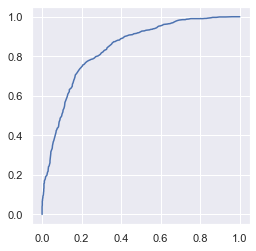

In [8]:
n1 = np.sum(cid_hold==1)
n0 = np.sum(cid_hold==0)

vals = ltr[:,1]/np.sum(ltr, axis=1)
thresholds = 1-np.logspace(-5, 0, 201)
thresholds[-1] = 0
thresholds[0] = 1
fprs = []
tprs = []
for thresh in thresholds:
    decisions_train = vals > thresh
    cm = sklearn.metrics.confusion_matrix(cid_hold, decisions_train)
    fprs.append(cm[0,1]/n0)
    tprs.append(cm[1,1]/n1)

# Plot ROC
plt.plot(fprs, tprs)
ax = plt.gca()
ax.axis('square')
auc = sklearn.metrics.auc(fprs, tprs)
print(f"AUC: {auc}")

# Constrained GMM for paired samples

In [9]:
from constr_gmm import constr_gmm
M=2
constr_gmm = constr_gmm(X,pair_ids,M,20,0)     
constr_gmm.run()
probs= constr_gmm.predict(Xhold)

AUC: 0.8438644749397667


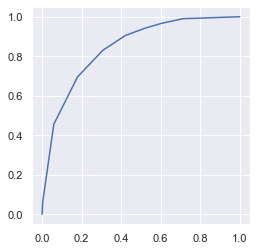

In [10]:
n1 = np.sum(cid_hold==1)
n0 = np.sum(cid_hold==0)

vals = probs[:,0]/np.sum(probs, axis=1)
thresholds = 1-np.logspace(-10,0,101)
thresholds[0] = 1
thresholds[-1] = 0
fprs_cgmm = []
tprs_cgmm = []
for thresh in thresholds:
    decisions = vals >= thresh
    cm = sklearn.metrics.confusion_matrix(cid_hold, decisions)
    fprs_cgmm.append(cm[0,1]/n0)
    tprs_cgmm.append(cm[1,1]/n1)
    
plt.plot(fprs_cgmm, tprs_cgmm)
ax = plt.gca()
ax.axis('square')
auc = sklearn.metrics.auc(fprs_cgmm, tprs_cgmm)
print(f"AUC: {auc}")

# MV-LVM

In [11]:
ng = Xg.shape[0]
nh = Xh.shape[0]
X1 = np.vstack((Xg[:ng//3,:],Xh[:nh//3,:]))
X2 = np.vstack((Xg[ng//3:2*(ng//3),:],Xh[nh//3:2*(nh//3),:]))
X3 = np.vstack((Xg[2*(ng//3):3*(ng//3),:],Xh[2*(nh//3):3*(nh//3),:]))

In [12]:
from clustering_methods import MVLVM
Xa = np.vstack((X1,X2))
sd = np.mean(np.std(Xa, axis=0))
sigma = sd*(2*n)**(-1/(d+4))
A, w = MVLVM(X1,X2,X3,k=2,sigma=sigma,reg=0.1)

In [13]:
import sklearn.neighbors 

xmin, xmax = -1.5, 2.5
ymin, ymax = -0.9, 1.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde0 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde0.fit(Xa, y=None, sample_weight=(A[:,0]).clip(1e-16))


#class 1
kde1 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde1.fit(Xa, y=None, sample_weight=(A[:,1]).clip(1e-16))

vals0 = kde0.score_samples(Xhold)
vals1 = kde1.score_samples(Xhold)

AUC: 0.6393767808748553


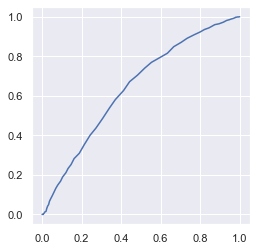

In [14]:
n1 = np.sum(cid_hold==1)
n0 = np.sum(cid_hold==0)


vals = vals0/(vals0+vals1)
thresholds = np.linspace(np.min(vals), np.max(vals), 101)
fprs_mvlvm = []
tprs_mvlvm = []
for thresh in thresholds:
    decisions_train = vals >= thresh
    cm = sklearn.metrics.confusion_matrix(cid_hold, decisions_train)
    fprs_mvlvm.append(cm[0,1]/n0)
    tprs_mvlvm.append(cm[1,1]/n1)
    
plt.plot(fprs_mvlvm, tprs_mvlvm)
ax = plt.gca()
ax.axis('square')
auc = sklearn.metrics.auc(fprs_mvlvm, tprs_mvlvm)
print(f"AUC: {auc}")

# NPMIX

In [15]:
from NPMIX import NPMIX
labels, ofit_gmm, gmm_assn = NPMIX(X, M=M, M_over=3*M)
probs = np.zeros((Xhold.shape[0],M))
for i in range(M):
    probs[:,i] = np.sum(ofit_gmm.predict_proba(Xhold)[:,gmm_assn==i], axis=1)
vals1 = np.log(probs[:,1])
vals0 = np.log(probs[:,0])

AUC: 0.5475490131037006


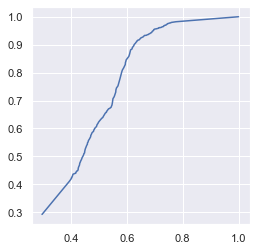

In [16]:
n1 = np.sum(cid_hold==1)
n0 = np.sum(cid_hold==0)

vals = vals1/(vals0+vals1)
thresholds = 1-np.logspace(-12, 0, 201)
thresholds[-1] = 0
thresholds[0] = 1
fprs_npmix = []
tprs_npmix = []
for thresh in thresholds:
    decisions_train = vals >= thresh
    cm = sklearn.metrics.confusion_matrix(cid_hold, decisions_train)
    fprs_npmix.append(cm[0,1]/n0)
    tprs_npmix.append(cm[1,1]/n1)
    
plt.plot(fprs_npmix, tprs_npmix)
ax = plt.gca()
ax.axis('square')
auc = sklearn.metrics.auc(fprs_npmix, tprs_npmix)
print(f"AUC: {auc}")

# KDE-plugin

In [17]:
kde0 = scipy.stats.gaussian_kde(X[component_ids==0].T, bw_method='scott')
kde1 = scipy.stats.gaussian_kde(X[component_ids==1].T, bw_method='scott')
vals0 = kde0(Xhold.T).T
vals1 = kde1(Xhold.T).T

In [18]:
n1 = np.sum(cid_hold==1)
n0 = np.sum(cid_hold==0)

vals = vals1/(vals0+vals1)
thresholds = 1-np.logspace(-5, 0, 201)
thresholds[-1] = 0
fprs_kde = []
tprs_kde = []
for thresh in thresholds:
    decisions_train = vals > thresh
    cm = sklearn.metrics.confusion_matrix(cid_hold, decisions_train)
    fprs_kde.append(cm[0,1]/n0)
    tprs_kde.append(cm[1,1]/n1)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


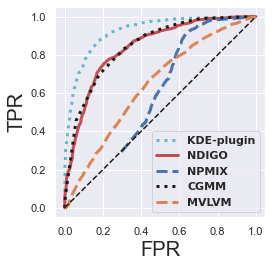

In [19]:
plt.plot(fprs_kde, tprs_kde, linestyle=":", color="c", linewidth=3)
plt.plot(fprs, tprs, linestyle="-", color="r", linewidth=3)
plt.plot(fprs_npmix, tprs_npmix, linestyle="--", linewidth=3)
plt.plot(fprs_cgmm, tprs_cgmm, linestyle=":", color="k", linewidth=3)
plt.plot(fprs_mvlvm, tprs_mvlvm, linestyle="--", linewidth=3)
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), linestyle="--", color='k')
ax = plt.gca()
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
ax.set_aspect('equal', 'box')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

labels = ['KDE-plugin', 'NDIGO', 'NPMIX', 'CGMM', 'MVLVM']
plt.legend(labels)
ax.axis('square')
plt.gcf().subplots_adjust(bottom=0.15)
# plt.savefig('magicROC.eps', format="eps")
# plt.savefig('magicROC.png', dpi=300)

## some of these might be below the line, which means the label was flipped
## if you rerun the these methods and flip the labels afterward it will be correct